# MODEL TRAINING

## 1.1 Importing required packages

In [5]:
%pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 10.7 MB/s eta 0:00:14
   - -------------------------------------- 3.9/150.0 MB 9.8 MB/s eta 0:00:15
   - -------------------------------------- 5.2/150.0 MB 8.6 MB/s eta 0:00:17
   - -------------------------------------- 6.6/150.0 MB 8.1 MB/s eta 0:00:18
   -- ------------------------------------- 7.9/150.0 MB 7.6 MB/s eta 0:00:19
   -- ------------------------------------- 9.2/150.0 MB 7.4 MB/s eta 0:00:20
   -- ------------------------------------- 10.7/150.0 MB 7.3 MB/s eta 0:00:20
   --- ------------------------------------ 12.1/150.0 MB 7.2 MB/s eta 0:00:20
   --- ------------------------------------ 13.4/150.0 MB 7.2 MB/s eta 0:00:20
   --- ------------------------------------ 14.7/150.0 MB 7.1 MB/s eta 0:00:20
   ---- ----------------------------------- 16.3/150.0 MB 7.1 MB/s eta 0:00:19
   ---- ----------------------------------- 17.6/150.0 MB 7.0 MB/

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#Modelling
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


## 1.2 Reading the file

In [7]:
df = pd.read_csv("data/stud.csv")

In [8]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 1.3 Setting math score as dependent variable, using the rest as independent variable


- Avg Score or Total score can also be used as the dependent variable
- Here, we are predicitng the math score using the data from the rest of the features

In [ ]:
X = df.drop(columns=["math_score"])
X

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [10]:
y = df["math_score"]
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math_score, dtype: int64

## 1.4 Data pre-processing

### 1.4.1 Cardinality of categorical features

In [12]:
cat_col = X.select_dtypes(include="object").columns
num_col = X.select_dtypes(exclude="object").columns
for i in cat_col:
    print(f"The unique values in {i} column are: {X[i].unique()}")

The unique values in gender column are: ['female' 'male']
The unique values in race_ethnicity column are: ['group B' 'group C' 'group A' 'group D' 'group E']
The unique values in parental_level_of_education column are: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
The unique values in lunch column are: ['standard' 'free/reduced']
The unique values in test_preparation_course column are: ['none' 'completed']


- As the cardinality of these categorical columns is not high, one hot encoding can be performed on them

In [13]:
cat_col

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')

In [14]:
num_col

Index(['reading_score', 'writing_score'], dtype='object')

### 1.4.2 Creating pipeline for data pre-processing

- Performing one hot encoding on categorical data followed by standardizing numerical data

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
cat_transformer= OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",cat_transformer, cat_col),
        ("StandardScaler", numeric_transformer, num_col),
    ]
)

In [18]:
X.shape

(1000, 7)

In [19]:
X = preprocessor.fit_transform(X)

In [20]:
X.shape


(1000, 19)

## 1.5 Splitting the data

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 19), (200, 19), (800,), (200,))

## 1.6 Creating an evaluate function to determine metrics

In [24]:
def evaluate_model(true, predicted):
    mae=mean_absolute_error(true, predicted)
    mse=mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

## 1.7 Defining and Training all model

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list=[]
r2_list=[]

for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train the model
    #Make prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #Evaluate and test model
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

## 1.8 Results

In [26]:
model_list

['Linear Regression',
 'Lasso',
 'Ridge',
 'K-Neighbors Regressor',
 'Decision Tree',
 'Random Forest Regressor',
 'XGBRegressor',
 'CatBoosting Regressor',
 'AdaBoost Regressor']

In [27]:
r2_list

[0.8804332983749565,
 0.8253197323627853,
 0.8805931485028737,
 0.7838129945787431,
 0.7173483511028264,
 0.8515551217860486,
 0.8277965784072876,
 0.8516318920747058,
 0.8456159244398576]

In [28]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
7,CatBoosting Regressor,0.851632
5,Random Forest Regressor,0.851555
8,AdaBoost Regressor,0.845616
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.717348


- As we can see both Ridge and Linear Regression have the best R2 score, let's select Linear Regression!

## 1.9 Linear Regression


In [30]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of this model is = %.2f" %score)


Accuracy of this model is = 88.04


##  2.0 Plot y_pred and y_test

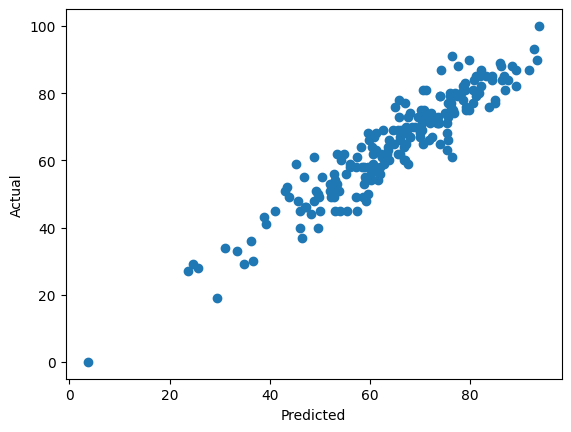

In [32]:
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

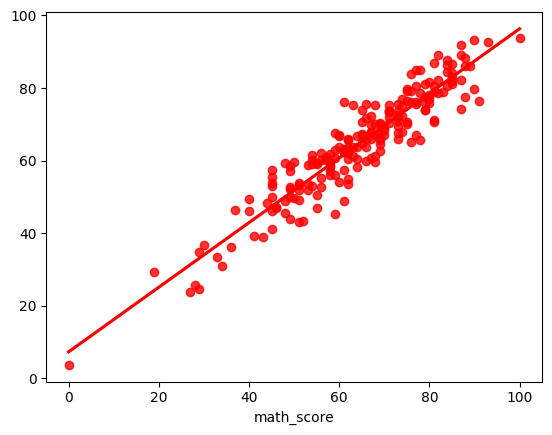

In [33]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [34]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
